# Load Libraries/ Data

In [118]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, roc_auc_score, precision_score

## Data concat

In [46]:
import pandas as pd
import seaborn as sns
from pylab import rcParams
import numpy as np
import matplotlib.pyplot as plt
from sklearn.impute  import SimpleImputer
from sklearn.model_selection import train_test_split

import pandas as pd
cross = pd.read_csv("/Users/zebyulon/Desktop/Margery/data/oasis_cross-sectional.csv")
long =  pd.read_csv("/Users/zebyulon/Desktop/Margery/data/oasis_longitudinal.csv")

cross_cp = cross.copy()

long_cp = long.copy()

#Since we will be predicting on the variable "CDR", we drop all the rows with undefined or null values

cross_cp.dropna(subset=['CDR'],inplace=True)
#cross_cp.isna().sum()

#Remove unnecessary columns in both datasets
cross_cp.drop(columns=['ID','Delay'],inplace=True)
long_cp = long.rename(columns={'EDUC':'Educ'})
long_cp.drop(columns=['Subject ID','MRI ID','Group','Visit','MR Delay'],inplace=True)
data = pd.concat([cross_cp,long_cp])
data_cp = data.copy()
data_cp.head()

,M/F,Hand,Age,Educ,SES,MMSE,CDR,eTIV,nWBV,ASF
0,F,R,74,2.0,3.0,29.0,0.0,1344,0.743,1.306
1,F,R,55,4.0,1.0,29.0,0.0,1147,0.810,1.531
2,F,R,73,4.0,3.0,27.0,0.5,1454,0.708,1.207
8,M,R,74,5.0,2.0,30.0,0.0,1636,0.689,1.073
9,F,R,52,3.0,2.0,30.0,0.0,1321,0.827,1.329


## Binary Data : Data_bi

In [47]:
data_cp['CDR'] = data_cp['CDR'].astype(str)
data_cp['CDR'] = data_cp['CDR'].str.replace('2','1')
data_bi = data_cp.copy()
ClassDict = {'0.0':0,'0.5':1,'1.0':1}
data_bi.loc[:,'CDR'] = data_bi.loc[:, 'CDR'].apply(lambda x: ClassDict[x])

In [48]:
data_bi

,M/F,Hand,Age,Educ,SES,MMSE,CDR,eTIV,nWBV,ASF
0,F,R,74,2.0,3.0,29.0,0,1344,0.743,1.306
1,F,R,55,4.0,1.0,29.0,0,1147,0.810,1.531
2,F,R,73,4.0,3.0,27.0,1,1454,0.708,1.207
8,M,R,74,5.0,2.0,30.0,0,1636,0.689,1.073
9,F,R,52,3.0,2.0,30.0,0,1321,0.827,1.329
...,...,...,...,...,...,...,...,...,...,...
368,M,R,82,16.0,1.0,28.0,1,1693,0.694,1.037
369,M,R,86,16.0,1.0,26.0,1,1688,0.675,1.040
370,F,R,61,13.0,2.0,30.0,0,1319,0.801,1.331
371,F,R,63,13.0,2.0,30.0,0,1327,0.796,1.323


# Data_explore

In [49]:
# we have to impute missing values in SES and MMSE. Lets analyze SES column

# Plotting distribution of SES
def univariate_mul(var):
    fig = plt.figure(figsize=(16,12))
    cmap=plt.cm.Blues
    cmap1=plt.cm.coolwarm_r
    ax1 = fig.add_subplot(221)
    ax2 = fig.add_subplot(212)
    long_cp[var].plot(kind='hist',ax=ax1, grid=True)
    ax1.set_title('Histogram of '+var, fontsize=14)
    
    ax2=sns.distplot(long_cp[[var]],hist=False)
    ax2.set_title('Distribution of '+ var)
    plt.show()

/var/folders/cj/_3zszdpj0q70j2kksbz8ccxr0000gn/T/ipykernel_2405/577147308.py:5: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(corr, dtype=np.bool)


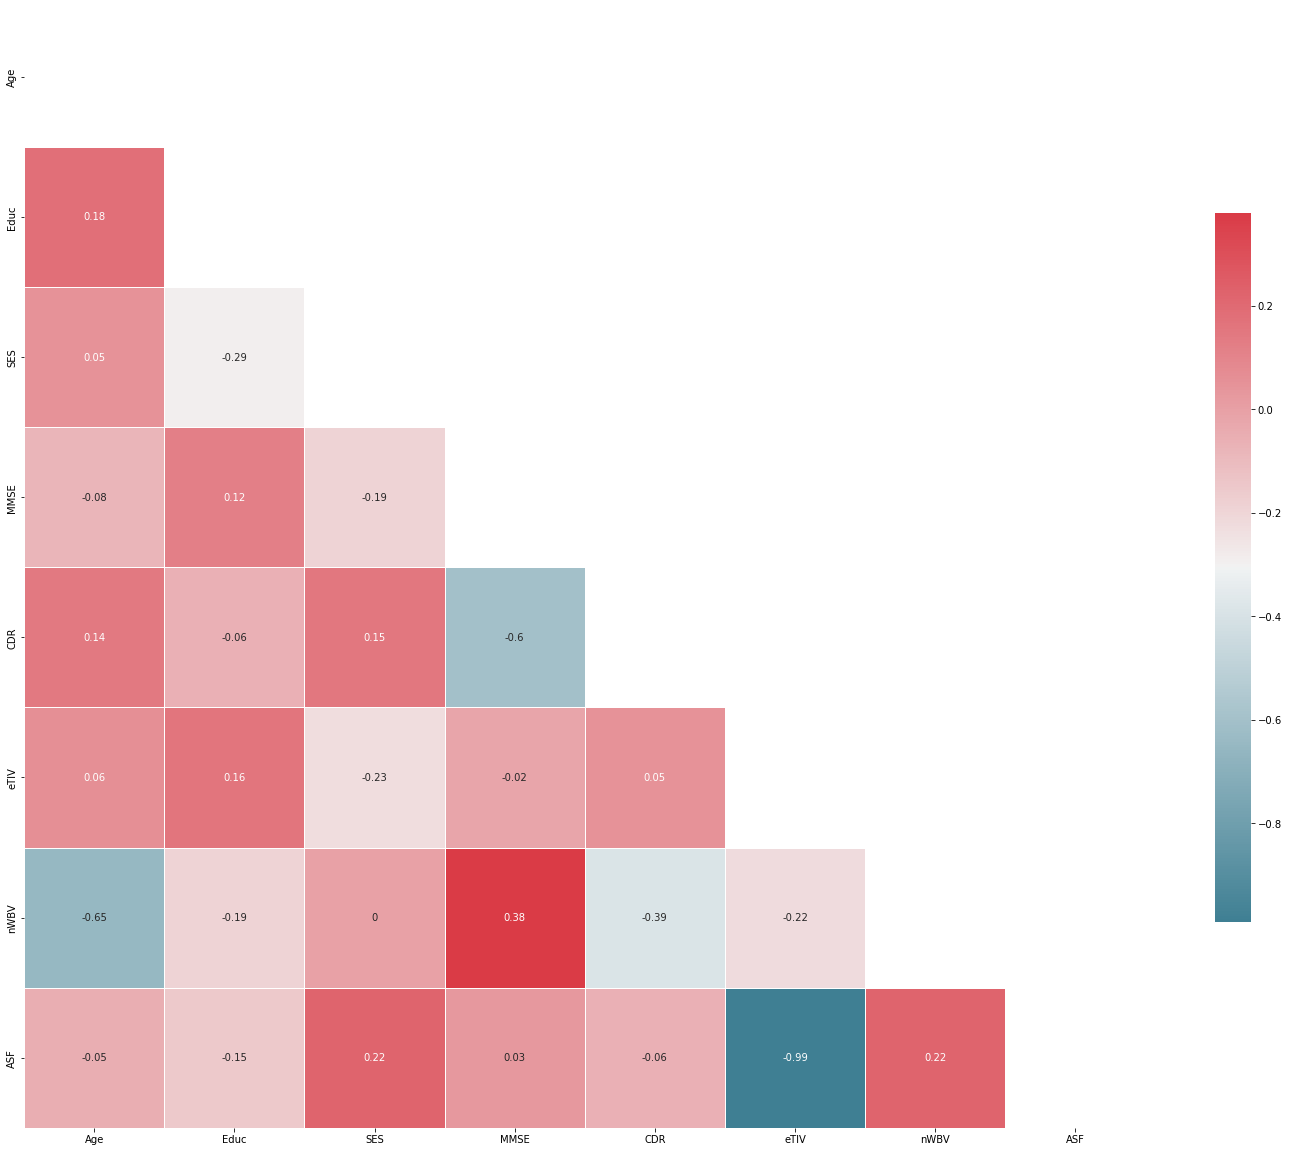

In [50]:
# Generate and visualize the correlation matrix
corr = data_bi.corr().round(2)

# Mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set figure size
f, ax = plt.subplots(figsize=(20, 20))

# Define custom colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap
sns.heatmap(corr, mask=mask, cmap=cmap,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

plt.tight_layout()

/Users/zebyulon/opt/miniforge3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


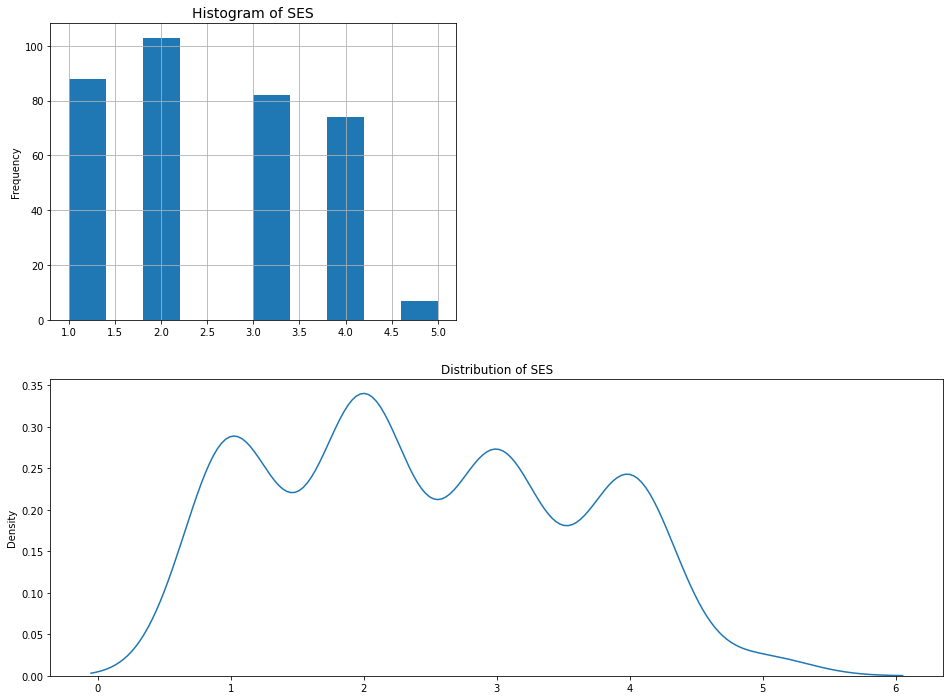

count    570.00000
mean       2.47193
std        1.12805
min        1.00000
25%        2.00000
50%        2.00000
75%        3.00000
max        5.00000
Name: SES, dtype: float64

In [51]:
# lets see the distribution of SES to decide which value we can impute in place of missing values.
univariate_mul('SES')
data_bi['SES'].describe()

/Users/zebyulon/opt/miniforge3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


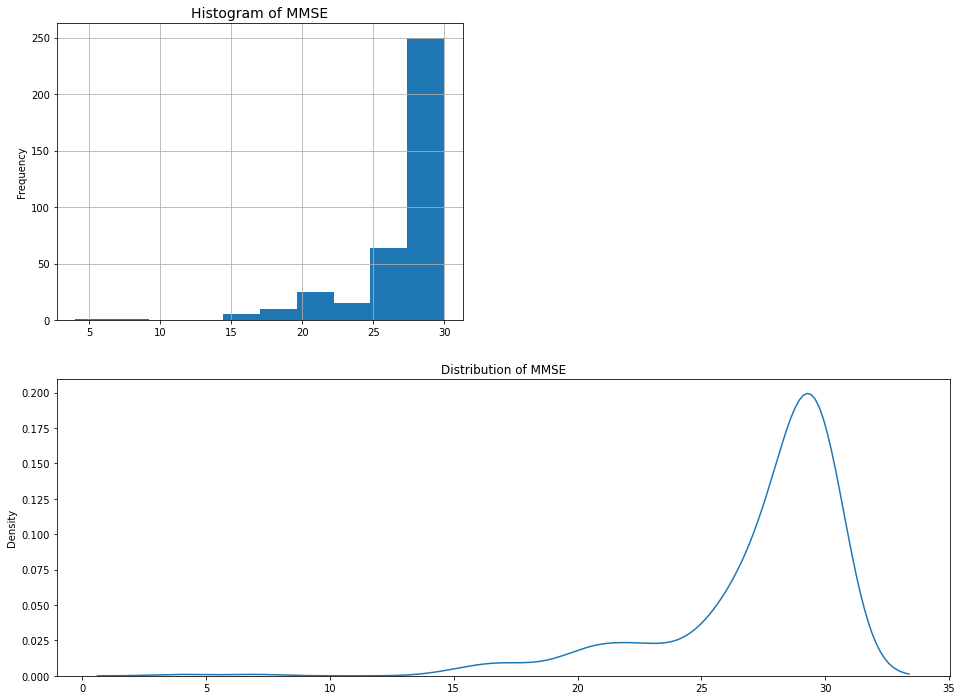

count    606.000000
mean      27.234323
std        3.687980
min        4.000000
25%       26.000000
50%       29.000000
75%       30.000000
max       30.000000
Name: MMSE, dtype: float64

In [52]:
univariate_mul('MMSE')
data_bi['MMSE'].describe()

/Users/zebyulon/opt/miniforge3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


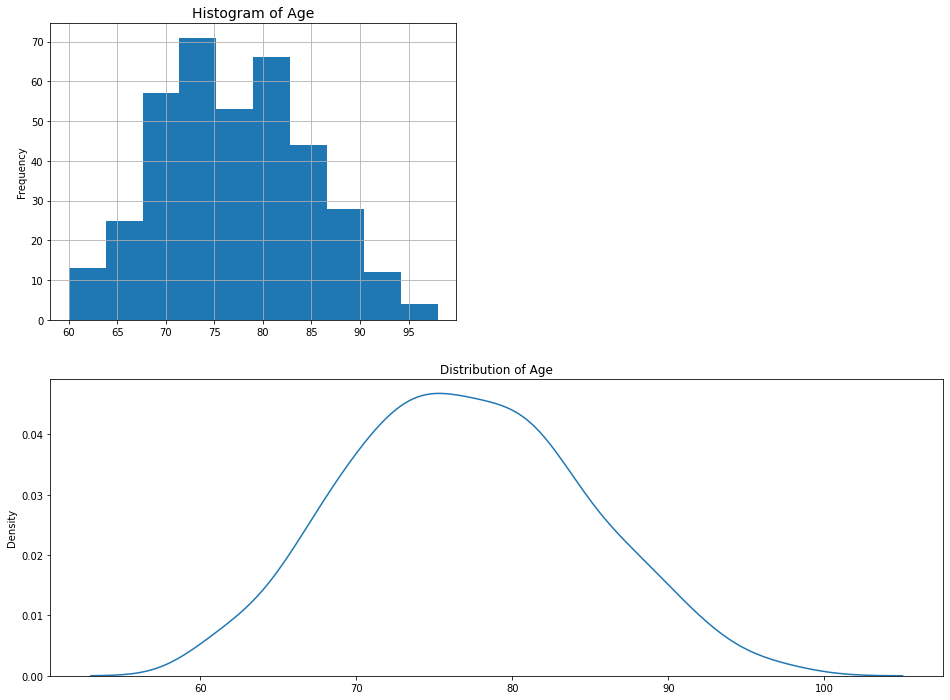

count    608.000000
mean      75.208882
std        9.865026
min       33.000000
25%       70.000000
50%       76.000000
75%       82.000000
max       98.000000
Name: Age, dtype: float64

In [53]:
univariate_mul('Age')
data_bi['Age'].describe()

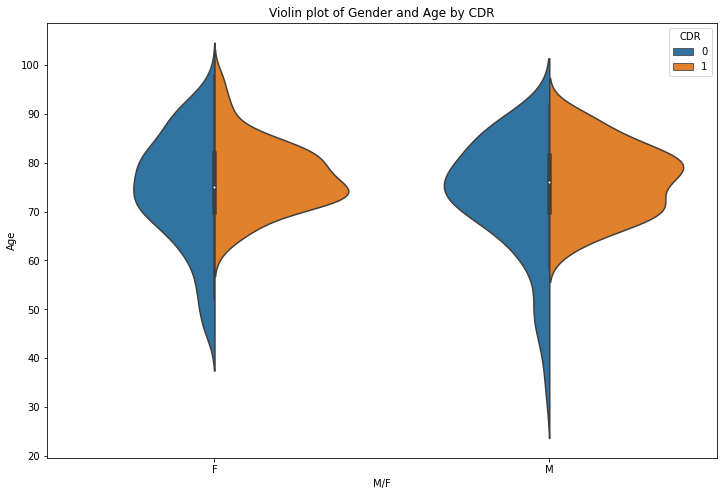

In [54]:
plt.figure(figsize=(12, 8))
ax = sns.violinplot(x="M/F", y="Age",hue="CDR",split=True, data=data_bi)
plt.title("Violin plot of Gender and Age by CDR")
plt.show()

In [55]:
data_bi['age_group'] = pd.cut(data_bi['Age'], [60, 70, 80,90, 100], labels=['60-70', '70-80', '80-90','90-100'])
data_bi['age_group'].value_counts()

70-80     263
80-90     162
60-70     120
90-100     22
Name: age_group, dtype: int64

In [56]:
# Plotting CDR with other variable
def univariate_percent_plot(cat):
    fig = plt.figure(figsize=(18,12))
    cmap=plt.cm.Blues
    cmap1=plt.cm.coolwarm_r
    ax2 = fig.add_subplot(222)
    group_by_stat = data_bi.groupby([cat, 'CDR']).size()
    group_by_stat.unstack().plot(kind='bar', stacked=True,ax=ax2,grid=True)
    ax2.set_title('stacked Bar Plot of '+ cat +' (in %)', fontsize=14)
    ax2.set_ylabel('Number of Cases')
    plt.show()



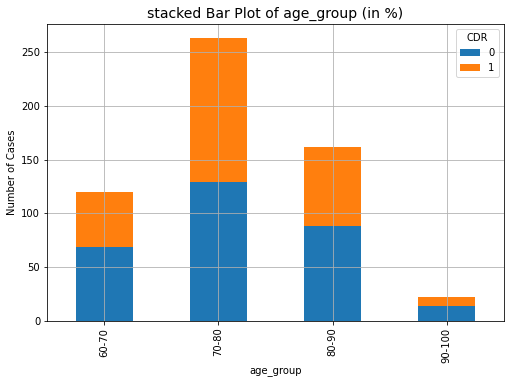

In [57]:
univariate_percent_plot('age_group')

In [58]:
# Defining function to create pie chart and bar plot as subplots
def plot_piechart(var):
  plt.figure(figsize=(14,7))
  plt.subplot(121)
  label_list = data_bi[var].unique().tolist()
  data_bi[var].value_counts().plot.pie(autopct = "%1.0f%%",colors = sns.color_palette("prism",7),startangle = 60,labels=label_list,
  wedgeprops={"linewidth":2,"edgecolor":"k"},shadow =True)
  plt.title("Distribution of "+ var +"  variable")

  plt.subplot(122)
  ax = data_bi[var].value_counts().plot(kind="barh")

  for i,j in enumerate(data_bi[var].value_counts().values):
    ax.text(.7,i,j,weight = "bold",fontsize=20)

  plt.title("Count of "+ var +" cases")
  plt.show()

# Data Clean

In [59]:
# remove ASF because it is almost correlated with eTIV 
# remove hand because all Right-handed
data_cp.drop(['ASF'],axis = 1,inplace = True)
data_cp.drop(['Hand'],axis = 1,inplace = True)
# Missing values imputer 
imputer = SimpleImputer ( missing_values = np.nan,strategy='most_frequent')
imputer.fit(data_cp[['SES']])
data_cp[['SES']] = imputer.fit_transform(data_cp[['SES']])

# We perform it with the median
imputer = SimpleImputer ( missing_values = np.nan,strategy='median')

imputer.fit(data_cp[['MMSE']])
data_cp[['MMSE']] = imputer.fit_transform(data_cp[['MMSE']])

In [60]:
# categogical data two numeric
gender_map = {'M':0, 'F':1}
data_cp['Gender'] = data_cp['M/F'].map(gender_map)
data_cp.drop(['M/F'],axis=1,inplace= True)

In [61]:
data_cp['CDR'].value_counts()

0.0    341
0.5    193
1.0     74
Name: CDR, dtype: int64

# Binary Classification

In [67]:
data_bi = pd.read_csv("~/data/data_bi.csv")

In [68]:
X_bi = np.asarray(data_bi[['Age','Educ','SES','MMSE','eTIV','nWBV','Gender']])
Y_bi = np.asarray(data_bi['CDR'])
validation_size = 0.20
seed = 42
X_train_bi, X_validation_bi, Y_train_bi, Y_validation_bi = train_test_split(X_bi, Y_bi, test_size=validation_size, random_state=seed)

In [69]:
data_bi['CDR'].value_counts()

0    341
1    267
Name: CDR, dtype: int64

In [70]:
models = []
models.append(('LR', LogisticRegression()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('RFC', RandomForestClassifier()))

In [71]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train_bi_sc = sc.fit_transform(X_train_bi)
X_validation_bi_sc= sc.transform(X_validation_bi)

## Algorithm Comparison

In [72]:
results = []
names = []
print('(', 'Model, ', 'Cross-Validation Accuracy: Mean, Stdev',')')
for name, model in models:
    kfold = KFold(n_splits=3, random_state = seed,shuffle=True)
    cv_results = cross_val_score(model, X_train_bi_sc, Y_train_bi, cv=kfold, scoring='accuracy')
    results.append(cv_results)
    names.append(name)
    msg = (name, format(cv_results.mean(), '.2f'))
    print(msg)

( Model,  Cross-Validation Accuracy: Mean, Stdev )
('LR', '0.79')
('KNN', '0.78')
('CART', '0.76')
('RFC', '0.83')


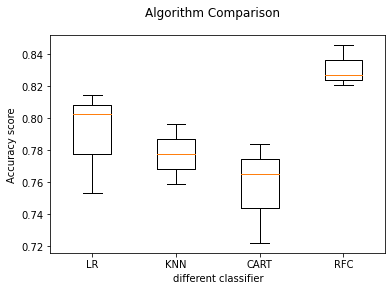

In [73]:
# Compare Algorithms
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
plt.xlabel("different classifier")
plt.ylabel("Accuracy score")
ax.set_xticklabels(names)
plt.show();

## RandomForest  Classifier

### n_estimator

0.8584678664910825 69


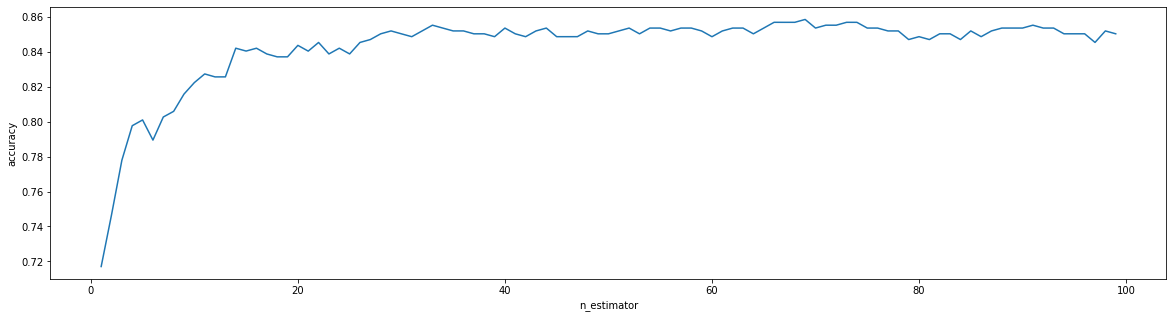

In [102]:
scorel = []
for i in range(1,100):
    rfc = RandomForestClassifier(n_estimators=i,
                                 n_jobs=-1,
                                 random_state=42)
    score = cross_val_score(rfc,X_bi, Y_bi,cv=3).mean()
    scorel.append(score)

print(max(scorel),([*range(1,100)][scorel.index(max(scorel))]))
plt.figure(figsize=[20,5])
plt.plot(range(1,100),scorel)
plt.xlabel("n_estimator")
plt.ylabel("accuracy")
plt.show()

### Parameters Tuning by GridSearchCV()

In [103]:
param_test = {
    
        
        'n_estimators':[69],
        'max_depth':range(1, 20, 1),
        'criterion':['gini', 'entropy'],
        'min_samples_leaf':np.arange(1, 1+10, 1)
    
        
    }
    
rfc = RandomForestClassifier(random_state=seed)

GS = GridSearchCV(rfc,param_test, scoring='roc_auc',cv=3)
GS.fit(X_train_bi, Y_train_bi)
print(GS.best_params_)
print(GS.best_score_)


{'criterion': 'entropy', 'max_depth': 13, 'min_samples_leaf': 1, 'n_estimators': 69}
0.9214613073104666


### Chosen Classifier Fit

In [104]:
rfc_bi = RandomForestClassifier(n_estimators=69,random_state=42,criterion='entropy',max_depth=13,min_samples_leaf=1,oob_score=True)
rfc_bi.fit(X_train_bi, Y_train_bi.ravel())

RandomForestClassifier(criterion='entropy', max_depth=13, n_estimators=69,
                       oob_score=True, random_state=42)

In [105]:
# Creating a confusion matrix
rfc_bi.fit(X_train_bi,Y_train_bi.ravel())
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
y_pred = rfc_bi.predict(X_validation_bi)
cm = confusion_matrix(Y_validation_bi, y_pred)
cm

array([[59,  2],
       [14, 47]])

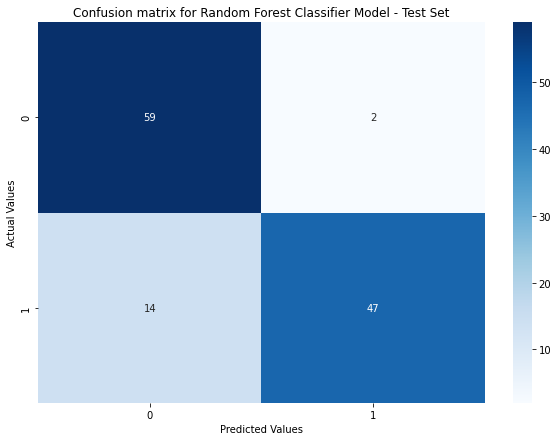

In [106]:
# Plotting the confusion matrix
plt.figure(figsize=(10,7))
p = sns.heatmap(cm, annot=True, cmap="Blues", fmt='g')
plt.title('Confusion matrix for Random Forest Classifier Model - Test Set')
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.show()

In [107]:
# ignore this code

modified_cm = []
for index,value in enumerate(cm):
    if index == 0:
        modified_cm.append(['TN = ' + str(value[0]), 'FP = ' + str(value[1])])
    if index == 1:
        modified_cm.append(['FN = ' + str(value[0]), 'TP = ' + str(value[1])])   
        

In [111]:
rfc_score = round(accuracy_score(Y_validation_bi, y_pred),4)*100

### Performance Report

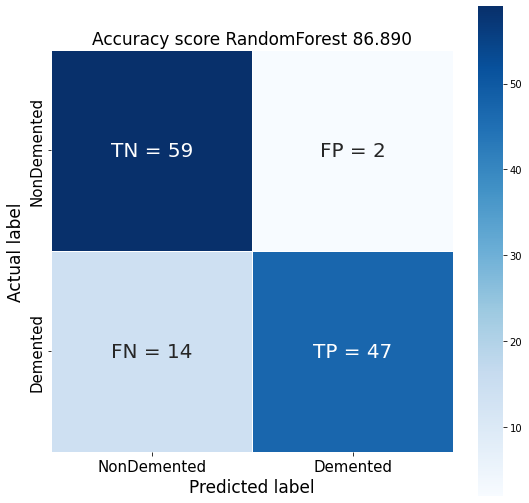

In [109]:
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=np.array(modified_cm),
            fmt="",
            annot_kws={"size": 20},
            linewidths=.5,
            square = True,
            cmap = 'Blues',
            xticklabels = ['NonDemented', 'Demented'],
            yticklabels = ['NonDemented', 'Demented'],
            );

plt.ylabel('Actual label', fontsize = 17);
plt.xlabel('Predicted label', fontsize = 17);
plt.title('Accuracy score RandomForest {:.3f}'.format(rfc_score), size = 17);
plt.tick_params(labelsize= 15)

In [112]:
rfc_try = rfc_bi
from sklearn.metrics import confusion_matrix, precision_score, accuracy_score, recall_score, roc_curve, auc
train_score = 0
test_score = 0
test_recall = 0
test_auc = 0

#rfc_try = RandomForestClassifier(n_estimators=51, random_state=42,max_depth = 5, criterion='gini').fit(X_train_l_sc, Y_train_l)
train_score = rfc_try.score(X_train_bi, Y_train_bi)
test_score = rfc_try.score(X_validation_bi, Y_validation_bi)
y_predict = rfc_try.predict(X_validation_bi)
#test_recall = recall_score(Y_validation_l, y_predict)
rfc_fpr, rfc_tpr, thresholds = roc_curve(Y_validation_bi, y_predict)
rfc_test_auc = auc(rfc_fpr, rfc_tpr)

print("Train accuracy ", train_score)
print("Test accuracy ", test_score)
#print("Test recall", test_recall)
print("Test AUC", rfc_test_auc)

Train accuracy  0.9979423868312757
Test accuracy  0.8688524590163934
Test AUC 0.8688524590163934


In [113]:
def report_performance(model):

    model_test = model.predict(X_validation_bi)
    fpr, tpr, thresholds = roc_curve(Y_validation_bi,model_test)
    test_auc = auc(fpr, tpr)
    print(model)
    print("\n\nConfusion Matrix:")
    print("{0}".format(metrics.confusion_matrix(Y_validation_bi, model_test)))
    print("\n\nClassification Report: ")
    print(metrics.classification_report(Y_validation_bi, model_test))
    print("test_score:")
    print(model.score(X_validation_bi, Y_validation_bi))
    print("train_score:")
    print(model.score(X_train_bi, Y_train_bi))
    print("TEST AUC")
    print(test_auc)
    print("RF OOB score:",rfc_bi.oob_score_)
    
    

In [116]:
report_performance(rfc_bi) 

RandomForestClassifier(criterion='entropy', max_depth=13, n_estimators=69,
                       oob_score=True, random_state=42)


Confusion Matrix:
[[59  2]
 [14 47]]


Classification Report: 
              precision    recall  f1-score   support

           0       0.81      0.97      0.88        61
           1       0.96      0.77      0.85        61

    accuracy                           0.87       122
   macro avg       0.88      0.87      0.87       122
weighted avg       0.88      0.87      0.87       122

test_score:
0.8688524590163934
train_score:
0.9979423868312757
TEST AUC
0.8688524590163934
RF OOB score: 0.8744855967078189


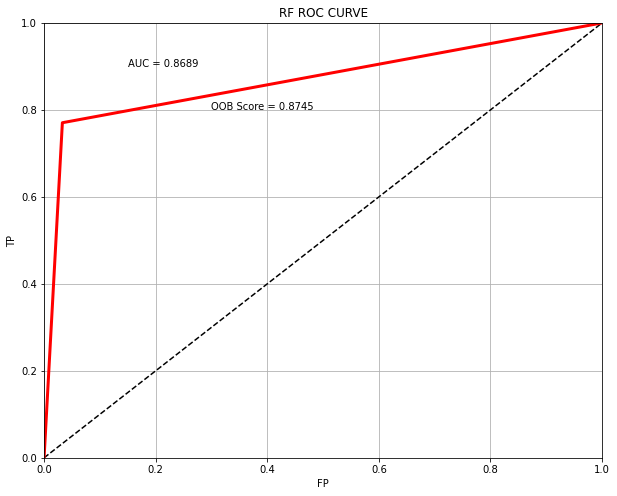

In [117]:

pre_y = rfc_bi.predict(X_validation_bi)
fpr_Nb, tpr_Nb, _ = roc_curve(Y_validation_bi, pre_y)
aucval = auc(fpr_Nb, tpr_Nb)    
plt.figure(figsize=(10,8))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_Nb, tpr_Nb,"r",linewidth = 3)
plt.grid()
plt.xlabel("FP")
plt.ylabel("TP")
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.title("RF ROC CURVE")
plt.text(0.15,0.9,"AUC = "+str(round(aucval,4)))
plt.text(0.30,0.8,"OOB Score = "+str(round(rfc_bi.oob_score_,4)))
plt.show()

## Logisitc Regression Classifier

### Build a Pipeline

In [176]:
# Create a pipeline
from sklearn.pipeline import Pipeline, make_pipeline
pipe = Pipeline([('scaler', StandardScaler()),
                 
                 ('logistic', LogisticRegression())])

pipe.fit(X_train_bi, Y_train_bi)

# Get Model Performance
print(pipe.score(X_validation_bi, Y_validation_bi))

0.8442622950819673


In [177]:
from sklearn import set_config

set_config(display='diagram')
pipe

Pipeline(steps=[('scaler', StandardScaler()),
                ('logistic', LogisticRegression())])

### Find best Hyparameter

In [157]:
param_grid = { 'C': [0.01,0.001,1,2,3,4,5,10,100]}

optimal_params = GridSearchCV(LogisticRegression(),
                             param_grid,
                             cv=3, # we are taking 5-fold as in k-fold cross validation # try the other scoring if have time
                             verbose=0,
                             n_jobs=-1)

optimal_params.fit(X_train_bi_sc, Y_train_bi)
print(optimal_params.best_params_)


{'C': 3}


In [178]:
model = make_pipeline(StandardScaler(),LogisticRegression(C=3))

model.fit(X_train_bi,Y_train_bi)

fpr, tpr, thresholds = roc_curve(Y_train_bi,model.predict_proba(X_train_bi)[:,1],drop_intermediate=False)

### Performance Report

In [179]:
train_score = 0
test_score = 0
test_recall = 0
test_auc = 0

log_reg_model = model.fit(X_train_bi, Y_train_bi)
train_score = model.score(X_train_bi, Y_train_bi)
test_score = model.score(X_validation_bi, Y_validation_bi)
scores = model.score(X_validation_bi, Y_validation_bi)
y_predict = model.predict(X_validation_bi)
#test_recall = recall_score(Y_validation_l, y_predict)
lgr_fpr, lgr_tpr, thresholds = roc_curve(Y_validation_bi, y_predict)
lgr_test_auc = auc(lgr_fpr, lgr_tpr)


print("Train accuracy ", train_score)
print("Test accuracy ", test_score)
#print("Test recall", test_recall)
print("Test AUC", lgr_test_auc)

Train accuracy  0.8065843621399177
Test accuracy  0.8524590163934426
Test AUC 0.8524590163934426


Text(0.5, 1.0, 'Accuracy score for Logisitic Regression 0.852')

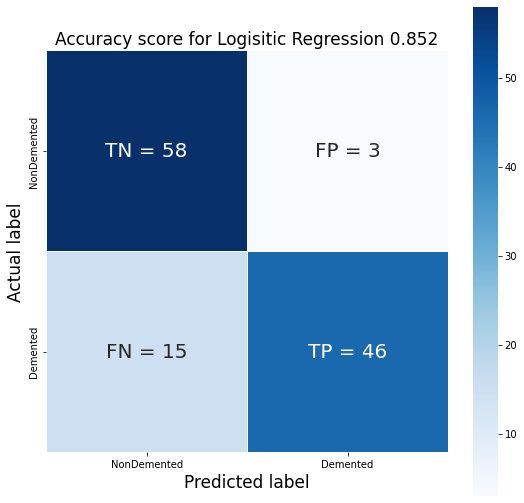

In [196]:
cm = metrics.confusion_matrix(Y_validation_bi,y_predict)
lg_score = accuracy_score(Y_validation_bi,y_predict)
modified_cm = []
for index,value in enumerate(cm):
    if index == 0:
        modified_cm.append(['TN = ' + str(value[0]), 'FP = ' + str(value[1])])
    if index == 1:
        modified_cm.append(['FN = ' + str(value[0]), 'TP = ' + str(value[1])])   
        
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=np.array(modified_cm),
            fmt="",
            annot_kws={"size": 20},
            linewidths=.5,
            square = True,
            cmap = 'Blues',
            xticklabels = ['NonDemented', 'Demented'],
            yticklabels = ['NonDemented', 'Demented'],
            );

plt.ylabel('Actual label', fontsize = 17);
plt.xlabel('Predicted label', fontsize = 17);
plt.title('Accuracy score for Logisitic Regression {:.3f}'.format(lg_score),size=17)


### Find Best Threshold

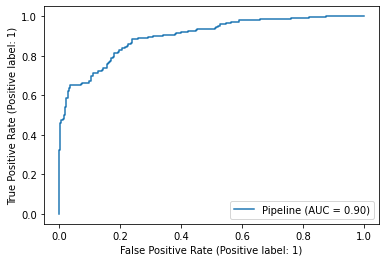

In [142]:
from sklearn.metrics import roc_curve,plot_roc_curve, balanced_accuracy_score
plot_roc_curve(pipe,X_train_bi,Y_train_bi)

In [145]:
fpr, tpr, thresholds = roc_curve(Y_train_bi,pipe.predict_proba(X_train_bi)[:,1],drop_intermediate=False)

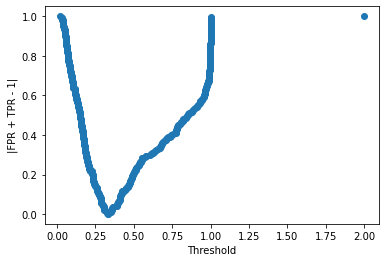

In [147]:
plt.scatter(thresholds,np.abs(fpr+tpr-1))
plt.xlabel("Threshold")
plt.ylabel("|FPR + TPR - 1|")
plt.show()

In [148]:
thresholds[np.argmin(np.abs(fpr+tpr-1))]


0.3312811939720864

### Logistic Regression Classifier with this threshold 

In [181]:
y_predict_prob = model.predict_proba(X_validation_bi)

In [184]:
# Extracting predicted probability of class 1
y_predict_prob_class_1 = y_predict_prob[:,1]

In [185]:
# Define threshold 
y_predict_class = [1 if prob > 0.3370621371894751 else 0 for prob in y_predict_prob_class_1]

In [189]:
cm = metrics.confusion_matrix(Y_validation_bi,y_predict_class )

In [190]:
cm

array([[52,  9],
       [ 9, 52]])

In [191]:
print('Accuracy %2.3f'%accuracy_score(Y_validation_bi,y_predict_class))
print('auc %2.3f'%roc_auc_score(Y_validation_bi,y_predict_class))

#print(recall_score(Y_validation_bi,y_pred),precision_score(Y_validation_bi,y_pred),f1_score(Y_validation_bi,y_pred))

Accuracy 0.852
auc 0.852


In [192]:
train_score = 0
test_score = 0
test_recall = 0
test_auc = 0

log_reg_model =  model.fit(X_train_bi, Y_train_bi)
train_score =  model.score(X_train_bi, Y_train_bi)
test_score =  model.score(X_validation_bi, Y_validation_bi)
scores = model.score(X_validation_bi, Y_validation_bi)

#test_recall = recall_score(Y_validation_l, y_predict)
lgr_fpr, lgr_tpr, thresholds = roc_curve(Y_validation_bi,y_predict_class)
lgr_test_auc = auc(lgr_fpr, lgr_tpr)


print("Train accuracy ", train_score)
print("Test accuracy ", test_score)
#print("Test recall", test_recall)
print("Test AUC", lgr_test_auc)

Train accuracy  0.8065843621399177
Test accuracy  0.8524590163934426
Test AUC 0.8524590163934427


Text(0.5, 1.0, 'Accuracy for Logisitic Regression with threshold P 0.852')

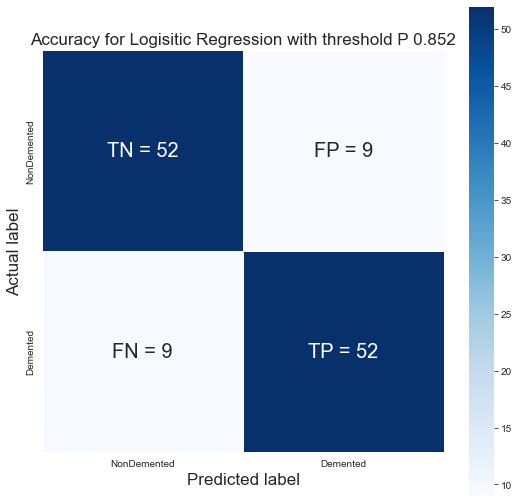

In [241]:
cm = metrics.confusion_matrix(Y_validation_bi,y_predict_class)
lg_score = accuracy_score(Y_validation_bi, y_predict_class)
modified_cm = []
for index,value in enumerate(cm):
    if index == 0:
        modified_cm.append(['TN = ' + str(value[0]), 'FP = ' + str(value[1])])
    if index == 1:
        modified_cm.append(['FN = ' + str(value[0]), 'TP = ' + str(value[1])])   
        
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=np.array(modified_cm),
            fmt="",
            annot_kws={"size": 20},
            linewidths=.5,
            square = True,
            cmap = 'Blues',
            xticklabels = ['NonDemented', 'Demented'],
            yticklabels = ['NonDemented', 'Demented'],
            );

plt.ylabel('Actual label', fontsize = 17);
plt.xlabel('Predicted label', fontsize = 17);
plt.title('Accuracy for Logisitic Regression with threshold P {:.3f}'.format(lg_score),size=17)


#### Report after tuning  threshold

In [204]:
print(classification_report(Y_validation_bi, y_predict_class))

              precision    recall  f1-score   support

           0       0.85      0.85      0.85        61
           1       0.85      0.85      0.85        61

    accuracy                           0.85       122
   macro avg       0.85      0.85      0.85       122
weighted avg       0.85      0.85      0.85       122



#### Report before tuning  threshold

In [207]:
print(classification_report(Y_validation_bi, y_predict))

              precision    recall  f1-score   support

           0       0.79      0.95      0.87        61
           1       0.94      0.75      0.84        61

    accuracy                           0.85       122
   macro avg       0.87      0.85      0.85       122
weighted avg       0.87      0.85      0.85       122



Although there is not some difference in the accuracy among 2 models, but the classifier after tuning threshold has better recall and less False Negative cases, so it is better when it comes to clinical diagnosis

# Multi - label Classification

## Split Train/ Test Data

In [212]:
X = np.asarray(data_cp[['Age','Educ','SES','MMSE','eTIV','nWBV','Gender']])
Y = np.asarray(data_cp['CDR'])
validation_size = 0.20
seed = 42
X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size=validation_size, random_state=seed)

## Imbalanced Data

<AxesSubplot:xlabel='CDR', ylabel='count'>

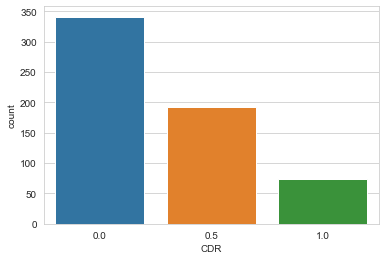

In [208]:
#see how many people have Alzheimer
#same person visits two or more time so only take the single visit data
sns.set_style("whitegrid")
sns.countplot(x='CDR', data=data_cp)

In [209]:
# Defining function to create pie chart and bar plot as subplots
def plot_piechart(var):
  plt.figure(figsize=(14,7))
  plt.subplot(121)
  label_list = data_cp[var].unique().tolist()
  data_cp[var].value_counts().plot.pie(autopct = "%1.0f%%",colors = sns.color_palette("prism",7),startangle = 60,labels=label_list,
  wedgeprops={"linewidth":2,"edgecolor":"k"},shadow =True)
  plt.title("Distribution of "+ var +"  variable")

  plt.subplot(122)
  ax = data_cp[var].value_counts().plot(kind="barh")

  for i,j in enumerate(data_cp[var].value_counts().values):
    ax.text(.7,i,j,weight = "bold",fontsize=20)

  plt.title("Count of "+ var +" cases")
  plt.show()

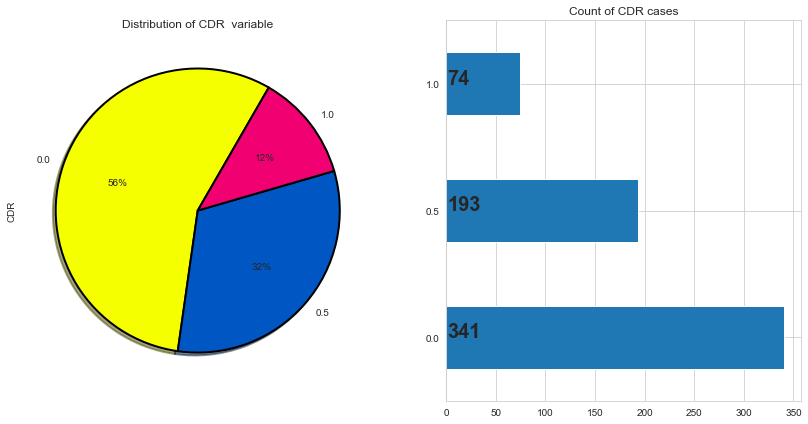

In [210]:
plot_piechart('CDR')

### OverSample

In [213]:
from imblearn.over_sampling import SMOTE
oversample =SMOTE()
X_re,Y_re = oversample.fit_resample(X_train,Y_train)
#X_re,Y_re = oversample.fit_resample(X_train,Y_train)
Y_reD = pd.DataFrame(Y_re, columns = ['CDR'])
#Y_reD.value_counts()

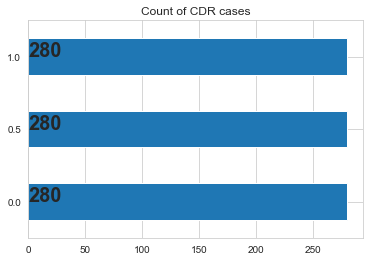

In [214]:
#plt.subplot(122)
ax = Y_reD['CDR'].value_counts().plot(kind="barh")

for i,j in enumerate(Y_reD['CDR'].value_counts().values):
    ax.text(.7,i,j,weight = "bold",fontsize=20)

plt.title("Count of "+ 'CDR' +" cases")
plt.show()

In [216]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train)
X_validation_sc = sc.transform(X_validation)
X_re_sc = sc.fit_transform(X_re)

## Algorithm comparison

### GridSearch

In [218]:
# Creating a function to calculate best model for this problem
def find_best_model(X, Y):
    models = {
        'logistic_regression': {
            'model': LogisticRegression(solver='newton-cg', multi_class='multinomial'),
            'parameters': {
                'C': [1,5,0.01]
               }
        },
        
        'decision_tree': {
            'model': DecisionTreeClassifier(splitter='best'),
            'parameters': {
                'criterion': ['gini', 'entropy'],
                'max_depth': [5,10,20]
            }
        },
        
        'random_forest': {
            'model': RandomForestClassifier(),
            'parameters': {
                'criterion': ['gini', 'entropy'],
                'n_estimators': [10,15,20,50,100,200],
                'max_depth': [5,6,7,8,9,10,11]
            }
        },
        
        'GradientBoosting':{
            'model': GradientBoostingClassifier(),
            'parameters':{
                'max_depth' : [4,5,6]
            }
        }

    }
    
    scores = [] 
        
    for model_name, model_params in models.items():
        gs = GridSearchCV(model_params['model'], model_params['parameters'], return_train_score=False)
        gs.fit(X, Y)
        scores.append({
            'model': model_name,
            'best_parameters': gs.best_params_,
            'score': gs.best_score_,
            
        })

    b =  pd.DataFrame(scores, columns=['model','best_parameters','score'])
    pd.set_option('max_colwidth',100)
    return b

find_best_model(X_re_sc, Y_re)


,model,best_parameters,score
0,logistic_regression,{'C': 1},0.686905
1,decision_tree,"{'criterion': 'gini', 'max_depth': 20}",0.780952
2,random_forest,"{'criterion': 'gini', 'max_depth': 11, 'n_estimators': 200}",0.869048
3,GradientBoosting,{'max_depth': 6},0.853571


### Cross_val_score

In [219]:
models = []
models.append(('LR', LogisticRegression()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('SVM', SVC()))
models.append(('GBM', GradientBoostingClassifier()))
models.append(('RFC', RandomForestClassifier()))

In [220]:
results = []
names = []
print('(', 'Model, ', 'Cross-Validation Accuracy: Mean, Stdev',')')
for name, model in models:
    kfold = KFold(n_splits=3, random_state = seed,shuffle=True)
    cv_results = cross_val_score(model, X_re_sc, Y_re, cv=kfold, scoring='accuracy')
    results.append(cv_results)
    names.append(name)
    msg = (name, format(cv_results.mean(), '.2f'))
    print(msg)

( Model,  Cross-Validation Accuracy: Mean, Stdev )
('LR', '0.69')
('CART', '0.78')
('SVM', '0.76')
('GBM', '0.82')
('RFC', '0.84')


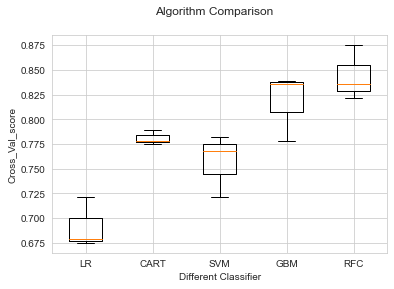

In [242]:
# Compare Algorithms
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.xlabel("Different Classifier")
plt.ylabel("Cross_Val_score")
plt.show();

## Hyparameter Tuning

0.8571428571428571 161


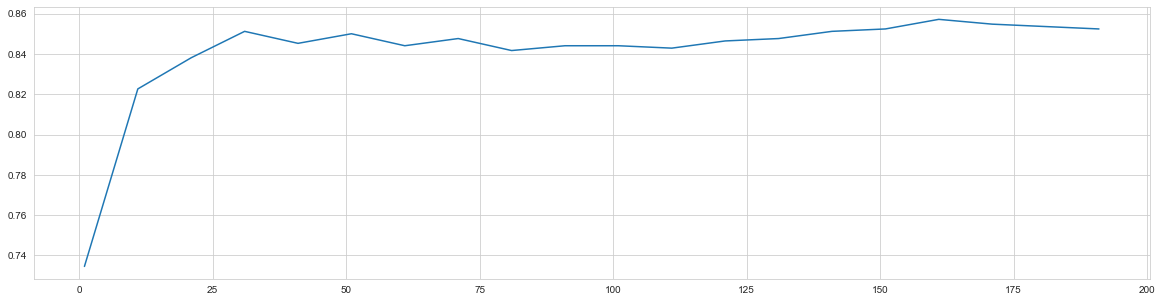

In [223]:
scorel = []
for i in range(0,200,10):
    rfc = RandomForestClassifier(n_estimators=i+1,
                                 n_jobs=-1,
                                 random_state=seed)
    score = cross_val_score(rfc,X_re,Y_re,cv=3).mean()
    scorel.append(score)

print(max(scorel),(scorel.index(max(scorel))*10)+1)
plt.figure(figsize=[20,5])
plt.plot(range(1,201,10),scorel)
plt.show()

In [262]:
param_test1 = {"n_estimators":range(1,200,10)}
gsearch1 = GridSearchCV(estimator=RandomForestClassifier(random_state=42),param_grid=param_test1,
                        scoring='accuracy',cv=3)
gsearch1.fit(X_re, Y_re)

print(gsearch1.best_params_)
#print(gsearch1.X_re_sc, Y_re)
print("best accuracy:%f" % gsearch1.best_score_)

{'n_estimators': 161}
best accuracy:0.857143


In [225]:
param_grid = {'max_depth':np.arange(1, 20, 1)}

rfc = RandomForestClassifier(n_estimators=161
                             ,random_state=42
                             )
GS = GridSearchCV(rfc,param_grid,cv=3)
GS.fit(X_re, Y_re)
print(GS.best_params_)
print(GS.best_score_)

{'max_depth': 14}
0.8571428571428571


In [226]:
param_grid = {'criterion':['gini', 'entropy']}
rfc = RandomForestClassifier(n_estimators=161
                             ,random_state=42,max_depth=14)
GS = GridSearchCV(rfc,param_grid,cv=3)
GS.fit(X_re_sc, Y_re)
print(GS.best_params_)
print(GS.best_score_)

{'criterion': 'entropy'}
0.8619047619047618


In [252]:
rfc = RandomForestClassifier(n_estimators=161,random_state=seed,criterion='entropy',max_depth=14)
score_mo = cross_val_score(rfc,X_re,Y_re,cv=3).mean()

In [250]:
print(score_mo )

0.8535714285714286


## Report performance

In [230]:
import itertools

In [255]:
rfc.fit(X_re, Y_re.ravel())

RandomForestClassifier(criterion='entropy', max_depth=14, n_estimators=161,
                       random_state=42)

In [256]:
def report_performance(model):

    model_test = model.predict(X_validation)

    print("\n\nConfusion Matrix:")
    print("{0}".format(metrics.confusion_matrix(Y_validation, model_test)))
    print("\n\nClassification Report: ")
    print(metrics.classification_report(Y_validation, model_test))
    cm = metrics.confusion_matrix(Y_validation, model_test)
    #plot_confusion_matrix(Y_validation_cr, model_test)

In [257]:
#importing accuracy_score, precision_score, recall_score, f1_score
y_pred = rfc.predict(X_validation)
y_test = Y_validation
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print('\nAccuracy: {:.2f}\n'.format(accuracy_score(y_test, y_pred)))

print('Micro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='micro')))
print('Micro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='micro')))

print('Macro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='macro')))
print('Macro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='macro')))
print('Macro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='macro')))

print('Weighted Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(y_test, y_pred, average='weighted')))

from sklearn.metrics import classification_report
print('\nClassification Report\n')
print(classification_report(y_test, y_pred, target_names=['Non-Dementia', 'Mild', 'Dementia']))


Accuracy: 0.80

Micro Precision: 0.80
Micro Recall: 0.80
Micro F1-score: 0.80

Macro Precision: 0.76
Macro Recall: 0.77
Macro F1-score: 0.76

Weighted Precision: 0.81
Weighted Recall: 0.80
Weighted F1-score: 0.80

Classification Report

              precision    recall  f1-score   support

Non-Dementia       0.85      0.95      0.90        61
        Mild       0.81      0.63      0.71        46
    Dementia       0.61      0.73      0.67        15

    accuracy                           0.80       122
   macro avg       0.76      0.77      0.76       122
weighted avg       0.81      0.80      0.80       122



In [258]:
cm = metrics.confusion_matrix(Y_validation,rfc.predict(X_validation))

In [259]:
classes=['CDR=1','CDR=0.5','CDR=0']

In [260]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
        if normalize:
            cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
            print("Normalized confusion matrix")
        else:
            print('Confusion matrix, without normalization')
        plt.figure(figsize=(11,8))
        plt.imshow(cm, interpolation='nearest', cmap=cmap)
        plt.title(title)
        #plt.colorbar()
        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks, classes, rotation=45)
        plt.yticks(tick_marks, classes)
        fmt = '.2f' if normalize else 'd'
        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, format(cm[i, j], fmt),
                    horizontalalignment="center",
                      color="white" if cm[i, j] > thresh else "black")
        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')

Confusion matrix, without normalization


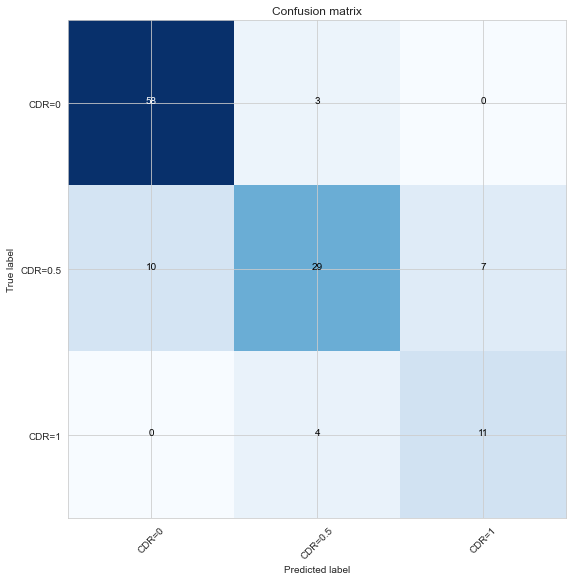

In [239]:
plot_confusion_matrix(cm,classes=['CDR=0','CDR=0.5','CDR=1'])

In [263]:
report_performance(rfc) 



Confusion Matrix:
[[58  3  0]
 [10 29  7]
 [ 0  4 11]]


Classification Report: 
              precision    recall  f1-score   support

         0.0       0.85      0.95      0.90        61
         0.5       0.81      0.63      0.71        46
         1.0       0.61      0.73      0.67        15

    accuracy                           0.80       122
   macro avg       0.76      0.77      0.76       122
weighted avg       0.81      0.80      0.80       122

